In [1]:
## PATH settings
import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.append(project_root)
COMMON_PATH = os.path.join(project_root, 'common')

In [2]:
## Bespoke class imports
from common.database.adatabase import ADatabase
from common.processor.processor import Processor as p
from financial_common.risk.rolling_factor_analysis import RollingFactorAnalysis
from financial_common.risk.single_index_capm import SingleIndexCAPM
from financial_common.indicator.indicator import Indicator
from financial_common.risk.risk_type import RiskType
from financial_common.risk.benchmark import Benchmark
from financial_common.portfolio_management.metrics import Metrics
from financial_common.portfolio_management.portfolio_selection import PortfolioSelection
import numpy as np

In [3]:
## Import standard packages
from datetime import timedelta
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from time import sleep
import copy

In [4]:
market = ADatabase("market")
fred = ADatabase("fred")

In [5]:
## Retrieve existing stocks 
market.connect()
index = market.retrieve("cryptocurrencies")
market.disconnect()

In [6]:
## Defining Benchmark
market.connect()
benchmark = market.query("crypto",{"ticker":"BTC-USD"})
benchmark = p.utc_date(benchmark)
benchmark["close"] = benchmark["close"].astype(float)
market.disconnect()
benchmark = Benchmark.convert_to_benchmark(benchmark,"close")

In [7]:
benchmark

,date,benchmark
349,2024-05-04 00:00:00+00:00,64023.45
348,2024-05-05 00:00:00+00:00,63162.24
347,2024-05-06 00:00:00+00:00,62315.76
346,2024-05-07 00:00:00+00:00,61169.53
345,2024-05-08 00:00:00+00:00,63073.57
...,...,...
4,2025-04-14 00:00:00+00:00,83629.78
3,2025-04-15 00:00:00+00:00,84028.72
2,2025-04-16 00:00:00+00:00,84961.97
1,2025-04-17 00:00:00+00:00,84466.47


In [8]:
market.connect()
prices = []
for ticker in tqdm(index["ticker"]): 
    try:
        price = market.query("crypto", {"ticker": ticker})
        for col in price.columns:
            if col not in ["date", "ticker"]:
                try:
                    price[col] = price[col].astype(float)
                    price.rename(columns={col:"adj"+col},inplace=True)
                except Exception as e:
                    print(str(e))
                    continue
        if price.index.size > 150:
            price = p.lower_column(price)
            price = p.utc_date(price)
        
            price.sort_values("date", inplace=True)
            price = p.additional_date_columns(price)
            for member in Indicator:
                price = member.calculate(price)
            for member in RiskType:
                price = member.apply(price)
            price = RollingFactorAnalysis.apply(price.merge(benchmark,on="date",how="left"),"adjclose","benchmark",100)
            prices.append(price)
    except Exception as e:
        print(str(e))
        continue
market.disconnect()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.70it/s]


In [9]:
model_end = 2024
backtest_end = 2026
simulation = pd.concat(prices).merge(index[["ticker","market_cap","industry"]],on="ticker",how="left")

## subsetting backtesting data
simulation = simulation[(simulation["year"]>=model_end) & (simulation["year"]<backtest_end)]
tickers = list(simulation[simulation["year"]==model_end]["ticker"].unique())
simulation = simulation[simulation["ticker"].isin(tickers)]

simulation.sort_values("date", inplace=True)
simulation.columns

Index(['adjstart', 'adjlow', 'adjhigh', 'adjopen', 'adjclose', 'adjvolume',
       'ticker', 'date', 'year', 'month', 'quarter', 'week', 'reference_price',
       'reference_volume', 'reference_high', 'reference_low',
       'rolling_dollar_volume', 'adr', 'sma', 'ema', 'bollinger_upper',
       'bollinger_lower', 'momentum', 'roc', 'williams_r', 'obv', 'vwap',
       'market_impact', 'atr', 'coefficient_of_variation', 'benchmark', 'cov',
       'var', 'beta', 'adjclose_prediction', 'market_cap', 'industry'],
      dtype='object')

In [10]:
portfolios = PortfolioSelection.generate_possible_portfolios(group_percentages=[0.05],grouping_columns=["industry"])

In [11]:
additional_portfolios = []

for portfolio in portfolios:
    for member in Indicator:
        portfolio_copy = copy.deepcopy(portfolio)
        portfolio_copy.ranking_metric = member.label
        additional_portfolios.append(portfolio_copy)


In [12]:
analysises = []
for portfolio in tqdm(additional_portfolios):
    try:
        trades = portfolio.trades(simulation.copy(),["market_cap"])
        performance = portfolio.portfolio(trades.copy(),benchmark.copy())
        metrics = Metrics.performance(trades,performance)
        results = {**portfolio.to_dict(),**metrics.copy()}
        results["portfolio"] = portfolio
        analysises.append(results)
    except Exception as e:
        print(str(e))
        continue

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 702/702 [01:29<00:00,  7.86it/s]


In [13]:
a = pd.DataFrame(analysises)
a.columns

Index(['timeframe', 'ranking_metric', 'position_type', 'selection_type',
       'allocation_type', 'risk_type', 'selection_percentage',
       'grouping_column', 'date', 'pnl', 'coefficient_of_variation',
       'portfolio_std', 'average_gain', 'average_loss', 'win_loss_ratio',
       'weekly_return', 'sharpe_ratio', 'portfolio'],
      dtype='object')

In [14]:
a.reset_index().drop("date",axis=1).sort_values("pnl",ascending=False).head(20)

,index,timeframe,ranking_metric,position_type,selection_type,allocation_type,risk_type,selection_percentage,grouping_column,pnl,coefficient_of_variation,portfolio_std,average_gain,average_loss,win_loss_ratio,weekly_return,sharpe_ratio,portfolio
78,78,quarter,rolling_dollar_volume,long,top,equal,coefficient_of_variation,0.05,industry,3.566405,2.831322,1.259625,1.758739,0.785598,0.600000,1.369482,1.754571,<financial_common.portfolio_management.portfol...
13,13,quarter,rolling_dollar_volume,short,mixed,equal,coefficient_of_variation,0.05,industry,3.314998,2.941125,1.127119,1.637215,0.724634,0.700000,1.363441,1.737789,<financial_common.portfolio_management.portfol...
80,80,quarter,sma,long,top,equal,coefficient_of_variation,0.05,industry,3.193512,2.585218,1.235297,1.614344,0.756102,0.700000,1.356871,1.487261,<financial_common.portfolio_management.portfol...
247,247,month,rolling_dollar_volume,short,mixed,equal,coefficient_of_variation,0.05,industry,3.189832,4.180407,0.763043,1.199453,0.892332,0.708333,1.109876,2.531246,<financial_common.portfolio_management.portfol...
82,82,quarter,bollinger_upper,long,top,equal,coefficient_of_variation,0.05,industry,3.117265,3.554816,0.876913,1.314377,0.992673,0.900000,1.282207,2.008138,<financial_common.portfolio_management.portfol...
256,256,month,obv,short,mixed,equal,coefficient_of_variation,0.05,industry,2.843060,3.935474,0.722419,1.215372,0.894465,0.625000,1.095032,2.193574,<financial_common.portfolio_management.portfol...
83,83,quarter,bollinger_lower,long,top,equal,coefficient_of_variation,0.05,industry,2.831916,3.888765,0.728230,1.668905,0.754047,0.600000,1.302962,2.026301,<financial_common.portfolio_management.portfol...
258,258,month,market_impact,short,mixed,equal,coefficient_of_variation,0.05,industry,2.413505,4.642058,0.519921,1.185702,0.864962,0.666667,1.078789,2.221727,<financial_common.portfolio_management.portfol...
6,6,quarter,momentum,long,mixed,equal,coefficient_of_variation,0.05,industry,2.293614,3.579172,0.640823,1.693903,0.760660,0.500000,1.227281,1.462669,<financial_common.portfolio_management.portfol...
106,106,quarter,sma,long,top,market_cap,coefficient_of_variation,0.05,industry,2.203161,4.179290,0.527161,1.307172,0.928900,0.700000,1.193690,1.606449,<financial_common.portfolio_management.portfol...


In [15]:
a["color"] = ["blue" if x == "top" else "red" if x == "bottom"  else "green" for x in a["selection_type"]]
a["return_to_risk"] = a["pnl"] / a["portfolio_std"]

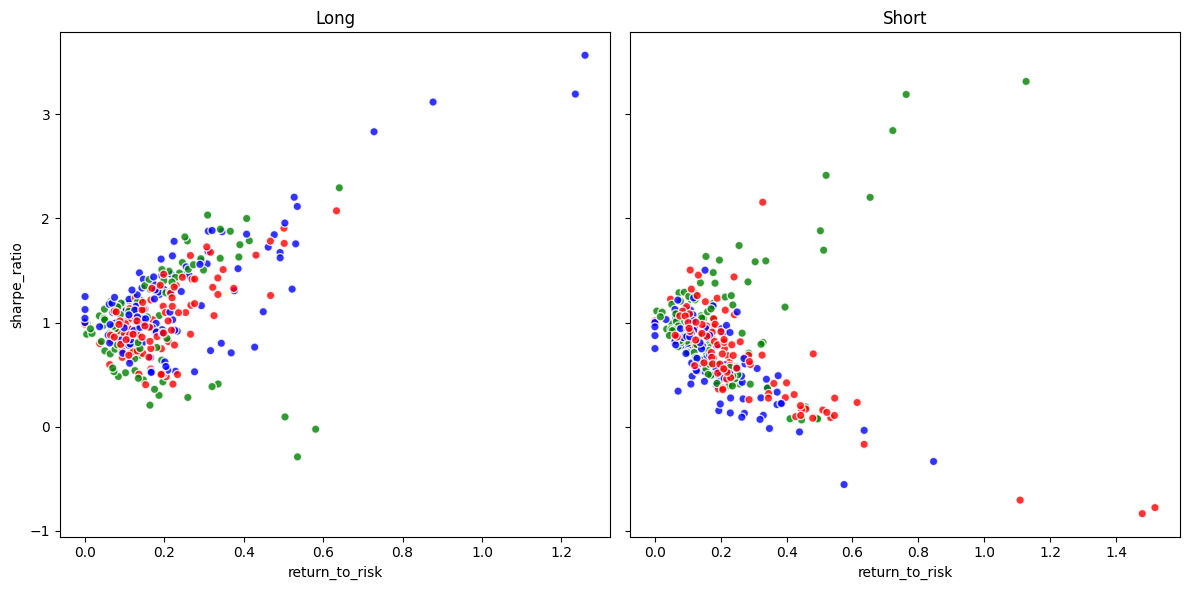

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Titles for each subplot
titles = ["Long", "Short"]

# Iterate over directions and corresponding axes
for i, position_type in enumerate(["long", "short"]):
    d_analysis = a[a["position_type"] == position_type]
    axes[i].scatter(
        d_analysis["portfolio_std"],
        d_analysis["pnl"],
        c=d_analysis["color"],
        alpha=0.8,
        edgecolors="w",
    )
    axes[i].set_title(titles[i])
    axes[i].set_xlabel("return_to_risk")
    axes[i].set_ylabel("sharpe_ratio" if i == 0 else "")  # Only label y-axis on the first plot

# Adjust layout for better spacing
plt.tight_layout()

# Show the combined plot
plt.show()

In [22]:
top = a[a["pnl"]>1].sort_values("coefficient_of_variation",ascending=True).head(1).to_dict("records")[0]
top

{'timeframe': 'month',
 'ranking_metric': 'ema',
 'position_type': 'long',
 'selection_type': 'top',
 'allocation_type': 'equal',
 'risk_type': 'coefficient_of_variation',
 'selection_percentage': 0.05,
 'grouping_column': 'industry',
 'date': Timestamp('2025-04-18 00:00:00+0000', tz='UTC'),
 'pnl': 1.1035317918718552,
 'coefficient_of_variation': 2.4565062197920815,
 'portfolio_std': 0.44922816925139236,
 'average_gain': 1.291693844485801,
 'average_loss': 0.8275310465058603,
 'win_loss_ratio': 0.4583333333333333,
 'weekly_return': 1.040272328913333,
 'sharpe_ratio': -0.3447013021999871,
 'portfolio': <financial_common.portfolio_management.portfolio.Portfolio at 0x1715d92a210>,
 'color': 'blue',
 'return_to_risk': 2.4565062197920815}

In [23]:
pm = top["portfolio"]
trades = pm.trades(simulation.copy(),["market_cap","beta"]).merge(index[["ticker","industry"]],on="ticker",how="left")
trades = p.additional_date_columns(trades)
portfolio = pm.portfolio(trades.copy(),benchmark.copy())
portfolio = p.additional_date_columns(portfolio)

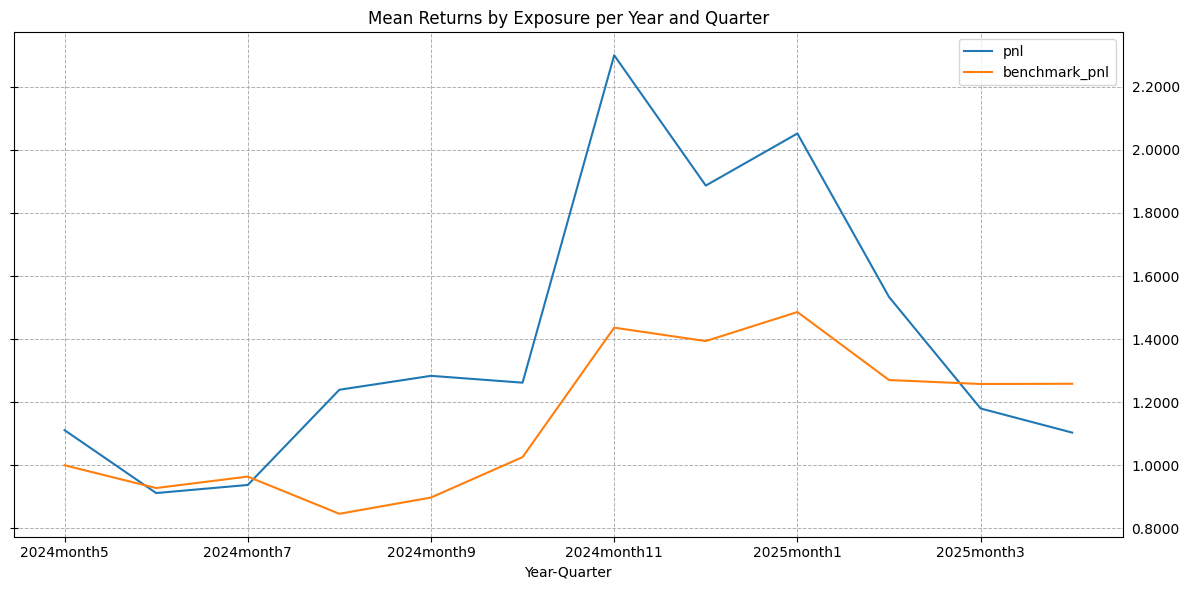

In [24]:
portfolio['Year-Quarter'] = portfolio["year"].astype(str) + pm.timeframe + portfolio[pm.timeframe].astype(str)
ax = portfolio[["Year-Quarter","pnl","benchmark_pnl"]].set_index("Year-Quarter").plot(
    kind="line",
    figsize=(12, 6),
    title="Mean Returns by Exposure per Year and Quarter"
)

# Set y-axis to have more precise ticks
ax.tick_params(axis='y', direction='in', length=6)  # Adjust y-tick direction and length
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.4f}'))  # Format y-ticks with 4 decimal places

# Move y-ticks to the right side
ax.yaxis.set_tick_params(which='both', direction='inout', length=6, labelleft=False, labelright=True)

# Optionally adjust the number of ticks for better precision
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=False, prune='both'))

# Add grid lines
ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.7)

# Display the plot
plt.tight_layout()
plt.show()

In [27]:
trades[["ticker","unweighted_return"]].groupby("ticker").mean().sort_values("unweighted_return",ascending=False)

,unweighted_return
ticker,
DOGE-USD,2.761030
SUI-USD,1.446926
HNT-USD,1.273332
AAVE-USD,1.150196
ETC-USD,1.067582
MKR-USD,0.984620
HBAR-USD,0.976328
XRP-USD,0.967135
SEI-USD,0.895060
